In [88]:
from qiskit_ibm_runtime import QiskitRuntimeService as QRS, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import numpy as np
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
import matplotlib.pyplot as plt

import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.linalg import expm, eig, eigh, svd

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator


def print_matrix(mat):
    for i in mat:
        print("| ", end ="")
        for j in range(len(i)):
            if j != len(i)-1: print(f"{i[j]:10}", end="\t\t")
            else: print(i[j], end="")
        print(" |")

pi = np.pi

from qiskit.quantum_info import Operator, SuperOp

In [ ]:
api_token = input("Enter API Token:")
service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)

In [42]:
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.device.models import basic_device_gate_errors
rpi_backend = service.backend('ibm_rensselaer')
properties = rpi_backend.properties()
gate_errors = basic_device_gate_errors(properties)


In [6]:
def create_hamiltonian(parameters, show_steps=False):
    scale_factor = parameters['scaling']
    shifting = parameters['shifting']
    if 'particles' in parameters.keys(): qubits = parameters['particles']
    else: qubits = 2
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    g = parameters['g']
    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if show_steps: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
    # peroidic bound
    temp = Pauli('')
    for j in range(qubits):
        if (j == 0 or j == qubits-1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    H += -temp.to_matrix()
    if show_steps: print("-"+str(temp)+" ", end='')
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        H += -g*temp.to_matrix()
        if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
    if show_steps: print("\n")


    
    # scale eigenvalues of the Hamiltonian
    n = 2**qubits
    largest_eigenvalue = np.abs(eigh(H, eigvals_only=True, subset_by_index=[n-1,n-1])[0])
    if show_steps: print("Largest Eigenvalue =", largest_eigenvalue)
    parameters["r_scaling"] = largest_eigenvalue/scale_factor
    H *= scale_factor/largest_eigenvalue
    H += shifting*np.eye(n)

    if show_steps:
        val, vec = eigh(H)
        print("Scaled eigenvalues:", val)
        print("Scaled eigenvectors:\n", vec)
        min_eigenvalue = np.min(val)
        print("Lowest energy eigenvalue", min_eigenvalue); print()
    
    return H

def hadamard_test(controlled_U, statevector, W = 'Re', shots=100):
    aer_sim = AerSimulator()
    trans_qc = create_hadamard_test(aer_sim, controlled_U, statevector, W = W)
    counts = aer_sim.run(trans_qc, shots = shots).result().get_counts()
    return calculate_re(counts, shots)

def create_hadamard_test(backend, controlled_U, W = 'Re'):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(controlled_U.num_qubits-1)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    qc.h(qr_eigenstate)
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    return qc

def calculate_re(counts, shots):
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas


In [ ]:
gate_errors = basic_device_gate_errors(properties)

error_types = set()
for name, qubits, error in gate_errors:
    error_types.add(name)
error_types = list(error_types)

noise_models = []
noise_models.append(NoiseModel())
for i in range(len(error_types)):
    noise_models.append(NoiseModel())

for i in noise_models:
    i.add_basis_gates(error_types)

for name, qubits, error in gate_errors:
    for i in range(len(error_types)):
        if name == error_types[i]: noise_models[i].add_quantum_error(error, name, qubits)

backend = AerSimulator(noise_model = noise_models[-1])

g = 1
shots = 10000

error_types.append('no noise')
errors = []
for i in error_types:
    errors.append([])
gates = []
for i in error_types:
    gates.append([])

qubit_trials = range(1,8)

for qubits in qubit_trials:
    tfim = create_hamiltonian({'scaling':1, 'shifting':0, 'g':g, 'particles':qubits})
    mat = expm(-1j*tfim*1)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc = create_hadamard_test(backend, controlled_U)
    tqc = transpile([qc], rpi_backend)
    for i in range(len(noise_models)):
        noise_model = noise_models[i]
        n_backend = AerSimulator(noise_model = noise_model)
        n_sampler = Sampler(n_backend)
        sampler   = Sampler(backend)
        job = sampler.run([tqc], shots = shots)
        result = job.result()[0].data[list(job.result()[0].data.keys())[0]]
        counts = result.get_counts()
        # print("noise", counts)
        p1 = calculate_re(counts, shots)

        job = n_sampler.run([tqc], shots = shots)
        result = job.result()[0].data[list(job.result()[0].data.keys())[0]]
        counts = result.get_counts()
        # print("no noise", counts)
        p2 = calculate_re(counts, shots)
        errors[i].append(abs(p1-p2))
    for i in range(len(error_types)):
        gates[i].append(tqc[0].depth(lambda x: x.operation.name==error_types[i]))

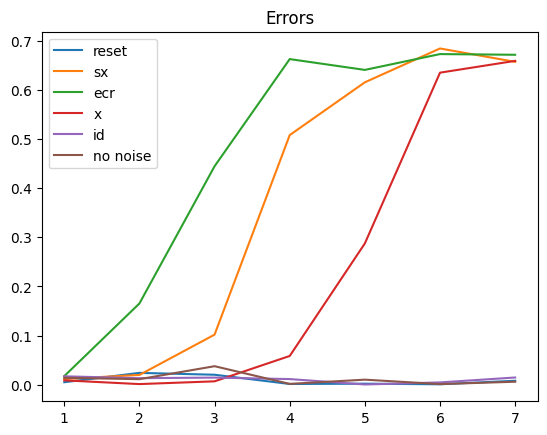

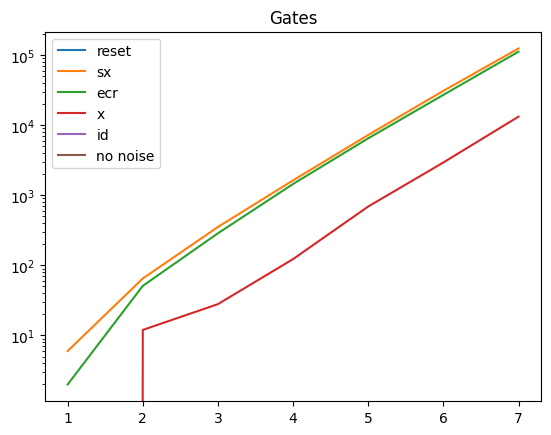

In [44]:
plt.title('Errors')
for i in range(len(errors)):
    error = errors[i]
    plt.plot(qubit_trials, error, label = error_types[i])
plt.legend()
# plt.yscale('log')
plt.show()

plt.title('Gates')
for i in range(len(gates)):
    gate = gates[i]
    plt.plot(qubit_trials, gate, label = error_types[i])
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
gate_errors = basic_device_gate_errors(properties)

error_types = set()
for name, qubits, error in gate_errors:
    error_types.add(name)
error_types = list(error_types)

noise_models = []
noise_models.append(NoiseModel())
for i in range(len(error_types)):
    noise_models.append(NoiseModel())

for i in noise_models:
    i.add_basis_gates(error_types)

for name, qubits, error in gate_errors:
    no_change = -1
    for i in range(len(error.circuits)):
        circuit = error.circuits[i]
        is_no_change = True
        for op in circuit.data:
            if op.name != 'id': is_no_change = False
        if is_no_change: no_change = i
    if no_change != -1:
        error_prob = 0
        for i in range(len(error.probabilities)):
            if i != no_change:
                error.probabilities[i] *= .3
                error_prob += error.probabilities[i]
        error.probabilities[no_change] = 1-error_prob
        for i in range(len(error_types)):
            if name == error_types[i]: noise_models[i].add_quantum_error(error, name, qubits)

backend = AerSimulator(noise_model = noise_models[-1])

g = 1
shots = 10000

error_types.append('no noise')
errors = []
for i in error_types:
    errors.append([])
gates = []
for i in error_types:
    gates.append([])

qubit_trials = range(1,5)

for qubits in qubit_trials:
    tfim = create_hamiltonian({'scaling':1, 'shifting':0, 'g':g, 'particles':qubits})
    mat = expm(-1j*tfim*1)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc = create_hadamard_test(backend, controlled_U)
    tqc = transpile([qc], rpi_backend)
    for i in range(len(noise_models)):
        noise_model = noise_models[i]
        n_backend = AerSimulator(noise_model = noise_model)
        n_sampler = Sampler(n_backend)
        sampler   = Sampler(backend)
        job = sampler.run([tqc], shots = shots)
        result = job.result()[0].data[list(job.result()[0].data.keys())[0]]
        counts = result.get_counts()
        # print("noise", counts)
        p1 = calculate_re(counts, shots)

        job = n_sampler.run([tqc], shots = shots)
        result = job.result()[0].data[list(job.result()[0].data.keys())[0]]
        counts = result.get_counts()
        # print("no noise", counts)
        p2 = calculate_re(counts, shots)
        errors[i].append(abs(p1-p2))
    for i in range(len(error_types)):
        gates[i].append(tqc[0].depth(lambda x: x.operation.name==error_types[i]))

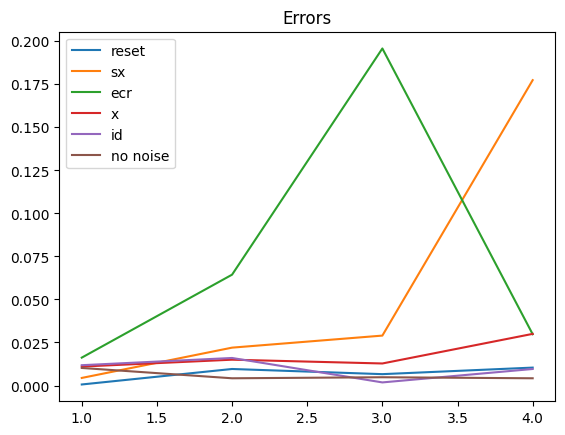

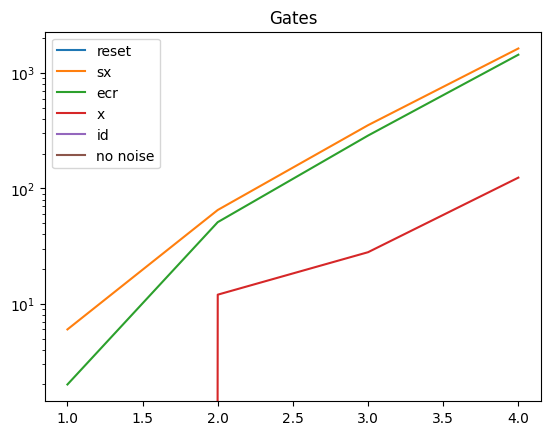

In [135]:
plt.title('Errors')
for i in range(len(errors)):
    error = errors[i]
    plt.plot(qubit_trials, error, label = error_types[i])
plt.legend()
# plt.yscale('log')
plt.show()

plt.title('Gates')
for i in range(len(gates)):
    gate = gates[i]
    plt.plot(qubit_trials, gate, label = error_types[i])
plt.legend()
plt.yscale('log')
plt.show()